# **Gaus-Newton method**
We deal with the minization problem of the objective function with the form
\begin{equation}
f(x) = \frac{1}{2} \| r(x) \|^2 = \frac{1}{2} \sum_{j=1}^m r_j( x )^2
\end{equation}
where the vectorial value function $r(x) = \left( r_1(x), \ldots, r_m(x) \right)^T$ is know as the residual function. Several computations can be simplified by employing the gradient 
of the residuals, we take $J(x) = \nabla r(x)$. The first and second order differentials of the function $f$ can be computed by employing the differentials of the residual function.
\begin{equation}
\nabla f(x) = \nabla r(x) r(x) = J(x)^T r(x)
\end{equation}

\begin{equation}
\nabla^2 f(x) = J(x)^T J(x) + \sum_{j=1}^m r_j(x) \nabla^2 r_j(x)
\end{equation}

In [1]:
import numpy as np
from scipy import sparse as sp
from scipy import linalg as la
from matplotlib import cm
from matplotlib import pyplot as plt

---
## **Line search with Wolfe conditions**

In [2]:
def line_search_wolfe( x, a, p, f, g, c1, c2, m ) :
  alpha_min = 0
  alpha = a
  alpha_max = np.inf

  fx = f( x )
  gx = g( x )
  hx = gx.dot( p )

  z = x + alpha * p
  fz = f( z )
  gz = g( z )
  hz = gz.dot( p ) 

  W1 = fx + alpha * c1 * hx
  W2 = c2 * hx
  i = 0
  while ( ( fz >= W1 or hz <= W2 ) and i < m ) :
    if fz > W1:
      alpha_max = alpha
      alpha = 0.5 * ( alpha_min + alpha_max )

    elif hz < W2 :
      if alpha_max >= np.inf :
        alpha = 2 * alpha
      else :
        alpha_min = alpha
        alpha = 0.5 * ( alpha_min + alpha_max )

    z = x + alpha * p
    fz = f( z )
    gz = g( z )
    hz = gz.dot( p )
    i = i + 1

  chk = fz > W1 or hz < W2

  return ( alpha, i, chk )

---
## **Algorithm for Gauss-Newton**
The Gauss-Newton method consist in the algorithm given by the following iterations at each $k \in \mathbb{N}$, starting with an initial $x_0 \in \mathbb{R}^n$
\begin{eqnarray}
  p_k & = & -\left( J(x_k)^T J(x_k) \right)^{-1} J( x_k ) r( x_k ) \\
  \alpha_k & = & \text{computed by line search} \\
  x_{k+1} & = & x_k + \alpha_k p_k
\end{eqnarray}

In [3]:
def gauss_newton( x, f, df, r, J, N, err, c1, c2, lsi ) :

  ng = 2 * err
  alpha = 1
  
  F = []
  G = []
  k = 0
  while k < N and ng > err :
    Jx = J( x )
    rx = r( x ) 
    p = np.linalg.lstsq( Jx, -rx, rcond = None )[0]
    [ alpha, i, chk ] = line_search_wolfe( x, alpha, p, f, df, c1, c2, lsi )
    x = x + alpha * p
    ng = la.norm( df( x ) )
    G.append( ng )
    F.append( f( x ) )
    k = k + 1

  return [ x, F, G, k ]

---
### **1. Example**
Now we consider the particular example with the objective function $f:\mathbb{R}^n \longrightarrow \mathbb{R}$
\begin{equation}
f(x) = \sum_{i=1}^{n+1} r_i(x)^2 = \|x\|^2 + \|x\|^4
\end{equation}

where the *residual function* $r: \mathbb{R}^n \longrightarrow \mathbb{R}^{n+1}$
\begin{equation}
r(x)
= \left[
\begin{array}{c}
x\\
\|x\|^2
\end{array}
\right]
\end{equation}

the gradient associated with $r$
\begin{equation}
J(x)
= \left[
\begin{array}{c}
I \\
2 x^T
\end{array}
\right]
\end{equation}

Convergence can be expected because for any $z \in \mathbb{R}^n$
\begin{equation}
\| J(x) z \| = \sqrt{ \|z\|^2 + 4 (x^T z)^2} \geq \|z\|
\end{equation}

In [4]:
def f( x ) :
  return la.norm( x )**2.0 + la.norm( x )**4.0

def r( x ) :
  return np.append( x, la.norm( x )**2.0 )

def J( x ):
  return np.append( np.eye( n ), np.reshape( 2 * x, ( 1, n ) ), axis = 0 )

def df( x ) :
  return J(x).T.dot( r(x) )

we apply the Gauss-Newton algorithm to the minimization problem of the previous function

In [5]:
n = 10

N = 20
err = 1e-30

c1 = 0.001
c2 = 0.5
lsi = 10
x = np.random.normal( 1, 5, n )

[ x, F, G, k ] = gauss_newton( x, f, df, r, J, N, err, c1, c2, lsi )
print( k )
print( x )
print( F[-1] )
print( G[-1] )

10
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
0.0


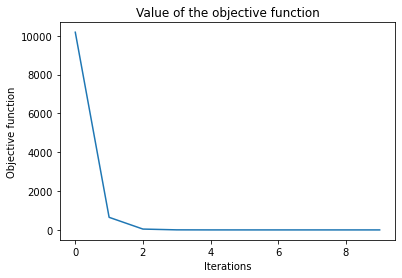

In [6]:
plt.xlabel( 'Iterations' )
plt.ylabel( 'Objective function' )
plt.title( 'Value of the objective function' )
plt.plot( F )

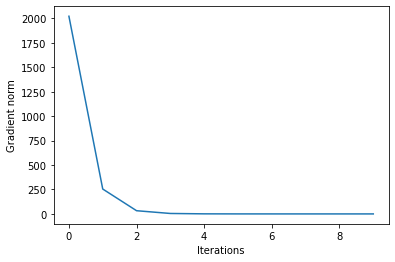

In [7]:
plt.xlabel( 'Iterations' )
plt.ylabel( 'Gradient norm' )
plt.plot( G )